# More regularization

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

In [26]:
import numpy as np
import numpy.random as npr
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
matplotlib.rcParams['font.size'] = 16

Topics:

- Why L1 leads to sparsity
- Regularization strength intuition, regularization paths, L1 vs. L2
- Why not use Huber regularization?
- Uniqueness of solution: L1 and L2
- Intercept and the mean value
- Scaling features
- Scaling targets
- Collinearity and conditioning
- Overfitting and $d>n$
- Loss function Venn diagram

## Why L1 regularization leads to sparsity

Consider this 1D case of a feature whose "true" weight is close to zero. Starting with no regularization:

$$f(w)=\sum_{i=1}^n (wx_i-y_i)^2$$

minimizer: w=-0.25


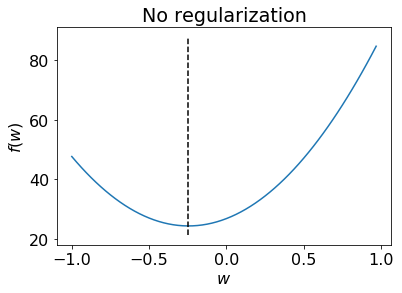

In [3]:
npr.seed(0)

# Generate random 1D data set
d = 1
n = 30
X = npr.randn(n,d)
y = npr.randn(n,1)
def f(w, X, y):
    return np.sum((X@w-y)**2,axis=0)

wgrid = np.arange(-1,1,2**(-5))
fw = f(wgrid[None], X, y)
minind = np.argmin(fw);
minw = wgrid[minind]
plt.plot(wgrid, fw);
plt.xlabel("$w$");
plt.ylabel("$f(w)$");
plt.plot((minw, minw),plt.ylim(),'--k');
plt.title("No regularization"); # $f(w)=\sum_{i=1}^n (wx_i-y_i)^2$
print("minimizer: w=%.2f" % minw);

Before proceeding, ask yourself: do you understand what this picture is showing? It's the parameter space, but in 1D, so we don't need a contour plot like we did in 2D.

#### L0 regularization

$$f(w)=\sum_{i=1}^n (wx_i-y_i)^2 + \lambda \|w\|_0$$

minimizer: w=0.00


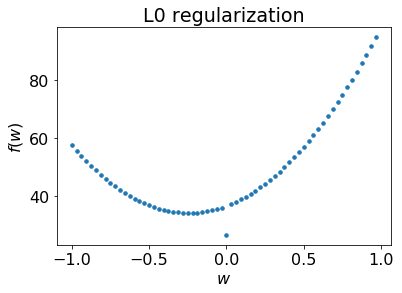

In [4]:
def f0(w, X, y, λ=10):
    return np.sum((X@w-y)**2,axis=0) + λ*(w!=0)
fw0 = f0(wgrid[None], X, y).ravel()
minind = np.argmin(fw0);
minw = wgrid[minind]
plt.plot(wgrid, fw0, '.',markersize=7);
# plt.plot((minw, minw),plt.ylim(),'--k');
# plt.plot(minw, fw0[minind], 'r*',markersize=10);
plt.xlabel("$w$");
plt.ylabel("$f(w)$");
plt.title("L0 regularization"); # $f(w)=\sum_{i=1}^n (wx_i-y_i)^2$
print("minimizer: w=%.2f" % minw);

- L0-regularized minimum is often exactly at the ‘discontinuity’ at 0:
  - Sets the feature to exactly 0 (does feature selection), but is **non-convex**.
  
- We can fiddle with the code to see a case where we don't get $w=0$:
  - By making the un-regularized solution further from 0.
  - By decreasing $\lambda$.


#### L2 regularization

$$f(w)=\sum_{i=1}^n (wx_i-y_i)^2 + \lambda \|w\|^2$$

minimizer: w=-0.06


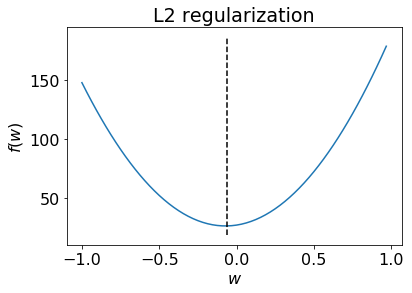

In [5]:
def f2(w, X, y, λ=100):
    return np.sum((X@w-y)**2,axis=0) + λ*np.sum(w**2,axis=0)
fw2 = f2(wgrid[None], X, y).ravel()
minind = np.argmin(fw2);
minw = wgrid[minind]
plt.plot(wgrid, fw2);
plt.plot((minw, minw),plt.ylim(),'--k');
# plt.plot(minw, fw0[minind], 'r*',markersize=10);
plt.xlabel("$w$");
plt.ylabel("$f(w)$");
plt.title("L2 regularization"); # $f(w)=\sum_{i=1}^n (wx_i-y_i)^2$
print("minimizer: w=%.2f" % minw);

- Note the solution is closer to zero than without regularization, but still not zero.
- Why? Because no incentive to move all the way to zero; the slope of the regularization term goes to zero!

#### L1 regularization

$$f(w)=\sum_{i=1}^n (wx_i-y_i)^2 + \lambda \|w\|_1$$

minimizer: w=0.00


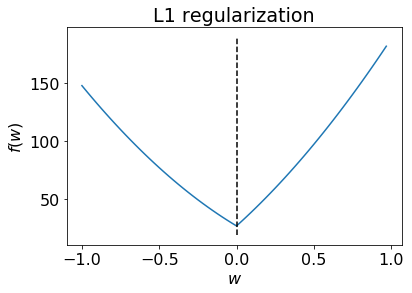

In [6]:
λ = 100
def f1(w, X, y, λ=100):
    return np.sum((X@w-y)**2,axis=0) + λ*np.sum(np.abs(w),axis=0)
fw1 = f1(wgrid[None], X, y).ravel()
minind = np.argmin(fw1);
minw = wgrid[minind]
plt.plot(wgrid, fw1);
plt.plot((minw, minw),plt.ylim(),'--k');
# plt.plot(minw, fw0[minind], 'r*',markersize=10);
plt.xlabel("$w$");
plt.ylabel("$f(w)$");
plt.title("L1 regularization"); # $f(w)=\sum_{i=1}^n (wx_i-y_i)^2$
print("minimizer: w=%.2f" % minw);

- Notice the solution is _exactly_ zero.
- Again, whether this happens depends on $\lambda$ and the original solution.

## Regularization strength intuition

Question: what is the effect of changing the regularization strength $\lambda$?

Let's take the oversimplified case of $n=1,d=1$ with no intercept and just one point at $(x_i,y_i)=(1,1)$. We can get zero training error by setting $w=1$:

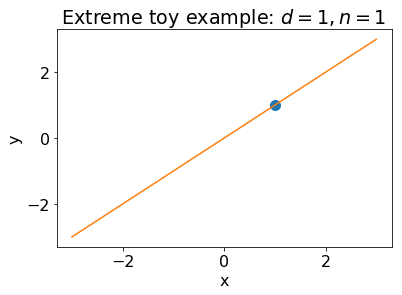

In [7]:
plt.plot(1,1,'.',markersize=20)
plt.plot((-3,3),(-3,3));
plt.xlabel("x");
plt.ylabel("y");
plt.title("Extreme toy example: $d=1,n=1$");

Our regularized loss is 

$$f(w)=(w-1)^2+\lambda w^2$$

- The left-hand term (data term) wants $w=1$
- The right-hand term (regularization term) wants $w=0$

In this particular case, because I picked such a simple example, we can do the math by hand. Taking the derivative and setting it to zero yields $\frac{df}{dw}=2(w-1)+2\lambda w=0$, so the minimum occurs at $w=\frac{1}{1+\lambda}$.

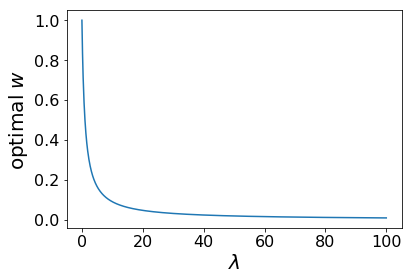

In [8]:
x = np.linspace(0,100,1000)
plt.plot(x, 1/(1+x))
plt.xlabel('$\lambda$', fontsize=20)
plt.ylabel('optimal $w$', fontsize=20);

This is a _regularization path_ but in the very simple case of just one $w$. We recover the limiting cases:

- $\lambda=0$ gives us $w=1$
- $\lambda \rightarrow \infty$ gives us $w=0$

All this pretty much generalizes to larger $n$ and $d$. So $\lambda$ controls the relative importance of training error vs. regularization.

#### Regularization paths

Here's an example with $d>1,n>1$:

In [18]:
d = 10
n = 30
w_true = npr.randn(d)*3
X = npr.randn(n,d)
y = npr.randn(n)/5 + X@w_true
λ_valsL2 = 10**np.linspace(-2,4,1000)
λ_valsL1 = 10**np.linspace(-2,2,1000)

WsL2 = np.zeros((len(λ_valsL2),d))
WsL1 = np.zeros((len(λ_valsL1),d))
for i,λ in enumerate(λ_valsL2):
    ridge = Ridge(alpha=λ)
    ridge.fit(X,y)
    WsL2[i] = ridge.coef_
for i,λ in enumerate(λ_valsL1):    
    lasso = Lasso(alpha=λ)
    lasso.fit(X,y)
    WsL1[i] = lasso.coef_

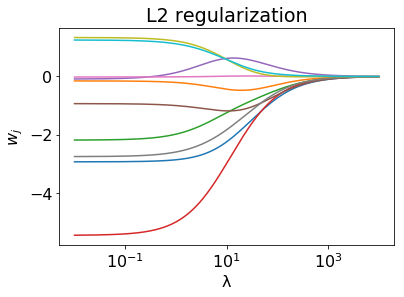

In [19]:
plt.semilogx(λ_valsL2, WsL2);
plt.xlabel("λ");
plt.ylabel("$w_j$");
plt.title("L2 regularization");

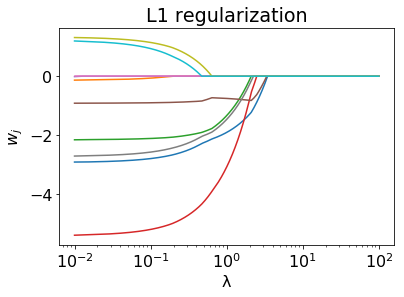

In [20]:
plt.semilogx(λ_valsL1, WsL1);
plt.xlabel("λ");
plt.ylabel("$w_j$");
plt.title("L1 regularization");

Notice how the weights "snap" to zero in the L1 case whereas they only approach 0 asymptotically in the L2 case.

(Bonus) Another question is what happens to regularization as $n$ gets large.

- As $n$ gets large, the loss term starts to dominate the regularization term for fixed $\lambda$, because it's a sum over $n$ things.
  - This appeals to our intuition, since we don't expect to overfit if we have lots of training data.
  - There's also a Bayesian interpretation coming later in the course.
- In theory, $\lambda$ should be $\Omega(1)$ and $O(n^{1/2})$ (hopefully those are the correct symbols!). 
  - If it grew linearly with $n$ then the loss and regularization would grow the same amount, which violates the above intuition about lots of training data.
- In practice, if we're choosing $\lambda$ with (cross)-validation anyway, we'll just get the value that works best.

## Why not use Huber regularization?

- Don’t confuse the L1 loss with L1-regularization!!!
  - L1-loss is robust to outlier data points.
    - You can use instead of removing outliers.
    - "sparse residuals"
  - L1-regularization is robust to irrelevant features.
    - You can use instead of removing features.
    - "sparse coefficients/weights"
- And note that you can use them together.
- Why aren’t we smoothing and using "Huber regularization"?
   - With the L1 loss, we cared about its behavior far from 0.
   - With L1 regularization, we care about its behavior near 0.
      - It’s precisely the non-smoothness that sets weights to exactly 0.

## Multiple choice question

Which of the following is true about L1 regularization? (There may be multiple that are true.)

1. For any value of $\lambda$, some of the $w$-values will be $0$.
2. For $\lambda \rightarrow \infty$ all of the $w$-values will be zero.
3. All the weights will be smaller than with L2 regularization, because you're not squaring them in the loss.
4. The regularization path is **not** a continuous function.


## Uniqueness of the solution: L1 and L2

- With no regularization, the solution is not unique. 
  - Example: two identical columns $i$ and $j$. 
    - If $(w_i,w_j)$ is a solution then $(w_j,w_i)$ is also a solution.
- With L1 regularization, the solution is also not unique. 
  - The same example applies.
- With L2 regularization, the solution is unique. 
  - If we have two identical columns $i$ and $j$ then $w_i=w_j$.
  
**The experiments shown below bonus material.**

In [21]:
npr.seed(0)

n = 20
X = npr.randn(n,1)
y = npr.randn(n,1) + 0.5*X**2 + X
X = np.concatenate((X,X),axis=1) # identical columns

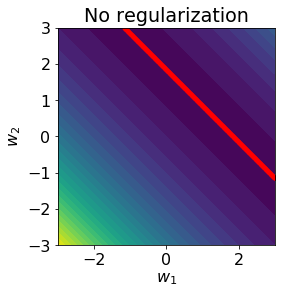

In [22]:
gridX = np.linspace(-3,3,1000)
gridY = np.linspace(-3,3,1000)
meshX, meshY = np.meshgrid(gridX, gridY)

def make_plot(loss_fun, **kwargs):
    loss = loss_fun(np.c_[meshX.ravel(), meshY.ravel()].T, X, y, **kwargs)
    min_inds = np.nonzero(loss<=np.min(loss)*(1+1e-7))
    loss = loss.reshape(meshX.shape[0],meshX.shape[1])
    # plt.imshow(loss,extent=(np.min(gridX), np.max(gridX), np.min(gridY), np.max(gridY)), origin='lower')
    CS = plt.contourf(gridX, gridY, loss, 30);
    plt.plot(meshX.flatten()[min_inds], meshY.flatten()[min_inds], '.r');
    plt.axis('square');
    # plt.colorbar();
    plt.xlabel('$w_1$');
    plt.ylabel('$w_2$');
make_plot(f)
plt.title("No regularization");

There is a "smear" of solutions (red) along the $w_1+w_2=w_\text{total}$ axis for some $w_\text{total}$.

In [23]:
lr = LinearRegression()
lr.fit(X,y)
print("w_total = %.4f"%np.sum(lr.coef_))

w_total = 1.7691


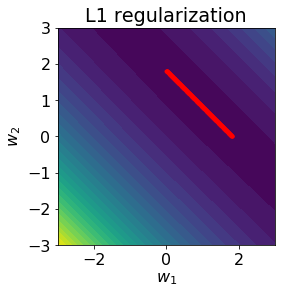

In [24]:
make_plot(f1, λ=1)
plt.title("L1 regularization");

- This is very interesting! We still have $w_1+w_2=w_\text{total}$ but...
- we can't have one of them take the opposite sign of $w_\text{total}$ (in this case positive).

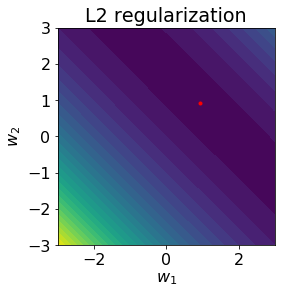

In [25]:
make_plot(f2, λ=0.1)
plt.title("L2 regularization");

With L2, the solution is unique. Why? This isn't a general proof but, try minimizing $w_1^2+w_2^2$ subject to $w_1+w_2=w_\text{total}$. You'll get $w_1=w_2$.


----------------

This is the dividng line between lecture 17 and lecture 18.

----------------

## Intercept and the mean value

One question is why we bother fitting an intercept: can't we just center the target values?

The answer is that the intercept isn't always going to be equal to the mean of the target values! For example:

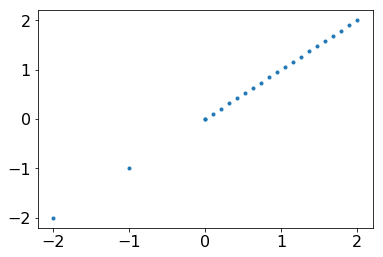

In [28]:
x = np.append(np.linspace(-2,0,3), np.linspace(0,2,20))
y = x
plt.plot(x,y,'.');

By visual inspection, the intercept here should be zero. Indeed:

In [29]:
lr = LinearRegression()
lr.fit(x[:,None],y)
lr.intercept_

0.0

And yet the mean is nonzero:

In [30]:
np.mean(y)

0.7391304347826086

## Scaling features

We've seen cases where scaling the features is important to get good performance. We can test this out by comparing the fits with and without scaling.

#### Without regularization

In [31]:
n = 100
d = 10
X = np.random.randn(n,d) 
X[:,0] = X[:,0]*1000 # make the first feature on a huge scale
y = np.sum(X,axis=1) + np.random.randn(n)
Xtest = np.random.randn(1,d)

lr = LinearRegression(normalize=False)
lr.fit(X,y)

lr_scale = LinearRegression(normalize=True)
lr_scale.fit(X,y)

np.allclose(lr.predict(Xtest), lr_scale.predict(Xtest))

True

#### L2 regularization

In [32]:
ridge = Ridge(normalize=False)
ridge.fit(X,y)

ridge_scale = Ridge(normalize=True)
ridge_scale.fit(X,y)

np.allclose(ridge.predict(Xtest), ridge_scale.predict(Xtest))

False

In [34]:
%autosave 0

Autosave disabled


#### L1 regularization

In [33]:
lasso = Lasso(normalize=False)
lasso.fit(X,y)

lasso_scale = Lasso(normalize=True)
lasso_scale.fit(X,y)

np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest))

False

Intuition: consider the simple case of $n=2,d=2$ with no intercept for simplicity. The data set consists of two points:

$$X=\begin{bmatrix} 1 & 0 \\ 0 & 1000 \end{bmatrix} \quad y=\begin{bmatrix} 1 \\ 1 \end{bmatrix}$$

The optimal weights are $$w=\begin{bmatrix} 1 \\ 0.001 \end{bmatrix}$$

In [35]:
X = np.array([[1, 0],[0, 1000]])
y = np.array([1,1])
lr = LinearRegression(fit_intercept=False)
lr.fit(X,y)
lr.coef_

array([1.   , 0.001])

In [36]:
ridge = Ridge(fit_intercept=False)
ridge.fit(X,y)
ridge.coef_

array([0.5  , 0.001])

The big coefficient got pushed down, but the small one pretty much got left alone. Therefore the _ratio of the coefficients_ changed. If we scaled the second feature by 1/1000 then we'd get coefficients that are the same. We can do the same with L1:

In [ ]:
lasso = Lasso(fit_intercept=False,alpha=0.1) # if alpha=1 then we snap one of the weights to zero
lasso.fit(X,y)
lasso.coef_

Conclusion:

- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

**Warning**: a common mistake is to scale test data with the mean/std of the test set. Need to use the same transformation as you used for the training data!

## Multiple choice question

If I'm **not** using regularization, what happens if I multiply one of the features by $2$ and re-compute $w$? (There may be multiple that are true.)

1. The corresponding weight is multiplied by $1/2$.
2. The corresponding weight is multiplied by $2$.
3. The predictions on the training data are changed.
4. The predictions on the training data are unchanged. 
5. The predictions on any test data (with the same transformation applied) are unchanged. 

## Scaling regression targets (bonus)

This one is a little more insidious than the feature scaling. It seems like it would never matter. But, let's compare the predictions with/without scaling the targets by a factor of 10.

#### No regularization

In [37]:
n = 100
d = 10
X = np.random.randn(n,d) 
y = np.sum(X,axis=1) + np.random.randn(n)
Xtest = np.random.randn(1,d)

lr = LinearRegression()
lr.fit(X,y)

lr_scale = LinearRegression()
scale_factor = 10
lr_scale.fit(X,y*scale_factor)

print("Predictions are the same with/without scaling?",)
np.allclose(lr.predict(Xtest), lr_scale.predict(Xtest)/scale_factor)

Predictions are the same with/without scaling?


True

#### L2 regularization

In [38]:
ridge = Ridge()
ridge.fit(X,y)

scale_factor = 10
ridge_scale = Ridge()
ridge_scale.fit(X,y*scale_factor)

print("Predictions are the same with/without scaling?",)
np.allclose(ridge.predict(Xtest), ridge_scale.predict(Xtest)/scale_factor)

Predictions are the same with/without scaling?


True

#### L1 regularization

In [39]:
lasso = Lasso()
lasso.fit(X,y)

scale_factor = 10
lasso_scale = Lasso()
lasso_scale.fit(X,y*scale_factor)

print("Predictions are the same with/without scaling?",)
np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest)/scale_factor)

Predictions are the same with/without scaling?


False

(To read over after class...) What's going on here?! With feature scaling it mattered for Ridge and Lasso, but here only Lasso is affected. Why? 

- If I scale the values of $y$ then I can account for this by scaling all the weights by the same amount
  - (it's cleaner to think about this without an intercept)
- So, for no regularization this is fine, predictions are also scaled
- For Ridge, if you scale the weights, _both terms in the loss_ are scaled by this factor squared
  - $f(w)=||Xw-y||^2_2 + \lambda ||w||_2^2$.
  - $f(cw)=c^2||Xw-y||^2_2 + c^2 \lambda ||w||_2^2 = c^2 f(w)$.
  - Thus it's just an overall scaling of the loss, which has no affect
- For Lasso, if you scale the weights, the first term is affected more than the second
  - $f(w)=||Xw-y||^2_2 + \lambda ||w||_1$.
  - $f(cw)=c^2||Xw-y||^2_2 + \lambda c ||w||_1$.
  - This, in essence, we've scaled $\lambda$ by $1/c$. Let's test this:
  

In [ ]:
lasso = Lasso() # default is alpha=1
lasso.fit(X,y)

scale_factor = 10
lasso_scale = Lasso(alpha=1*scale_factor)
lasso_scale.fit(X,y*scale_factor)

np.allclose(lasso.predict(Xtest), lasso_scale.predict(Xtest)/scale_factor)

The universe makes sense -- nice!

If we were picking $\lambda$ (a.k.a. `alpha`) with cross-validation then this should not end up mattering, so long as we did any scaling _before_ we picked $\lambda$.

## Collinearity and conditioning (bonus)

#### The "dummy variable trap"

In [40]:
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset("titanic").dropna()
titanic_small = titanic[["age","fare","embark_town"]]
titanic_small.head()

,age,fare,embark_town
1,38.0,71.2833,Cherbourg
3,35.0,53.1000,Southampton
6,54.0,51.8625,Southampton
10,4.0,16.7000,Southampton
11,58.0,26.5500,Southampton


We talked about converting categorical to numerical:

In [41]:
titanic_small_dummy = pd.get_dummies(titanic_small)
titanic_small_dummy.head()

,age,fare,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
1,38.0,71.2833,1,0,0
3,35.0,53.1000,0,0,1
6,54.0,51.8625,0,0,1
10,4.0,16.7000,0,0,1
11,58.0,26.5500,0,0,1


Let's say we're predicting age from the fare and town.

In [42]:
X = titanic_small_dummy.values.astype('float')
y = X[:,0]
X = X[:,1:]

In [44]:
lr = LinearRegression()
lr.fit(X, y)
old_coef = lr.coef_
old_coef

array([-0.0244833 ,  1.05209929,  1.76389238, -2.81599166])

In [45]:
Xnew = X.copy()
Xnew[0,-1] += 1e-8 # tiny perturbation
lr.fit(Xnew, y)
new_coef = lr.coef_
np.abs(new_coef[-1] - old_coef[-1])

25056447.18721889

Wow, what just happened??? We changed a value by $10^{-8}$ and the coefficient changed by a giant amount?

But wait, what it's actually doing is fitting an intercept, meaning a column of ones:

In [46]:
Xint = np.append(X, np.ones((X.shape[0],1)),axis=1)

In [47]:
print(Xint)

[[ 71.2833   1.       0.       0.       1.    ]
 [ 53.1      0.       0.       1.       1.    ]
 [ 51.8625   0.       0.       1.       1.    ]
 [ 16.7      0.       0.       1.       1.    ]
 [ 26.55     0.       0.       1.       1.    ]
 [ 13.       0.       0.       1.       1.    ]
 [ 35.5      0.       0.       1.       1.    ]
 [263.       0.       0.       1.       1.    ]
 [ 76.7292   1.       0.       0.       1.    ]
 [ 61.9792   1.       0.       0.       1.    ]
 [ 83.475    0.       0.       1.       1.    ]
 [ 10.5      0.       0.       1.       1.    ]
 [  7.65     0.       0.       1.       1.    ]
 [263.       0.       0.       1.       1.    ]
 [ 61.175    0.       0.       1.       1.    ]
 [ 34.6542   1.       0.       0.       1.    ]
 [ 63.3583   1.       0.       0.       1.    ]
 [ 77.2875   0.       0.       1.       1.    ]
 [ 52.       0.       0.       1.       1.    ]
 [247.5208   1.       0.       0.       1.    ]
 [ 13.       0.       0.       1.       

The "dummy variable" columns add up to the intercept column; we've introduced perfect collinearity! (The rank of this matrix is 4, not 5.)

In [48]:
np.linalg.matrix_rank(X)

4

In [49]:
np.linalg.matrix_rank(Xint)

4

Pandas' `get_dummies` has an argument `drop_first` which helps avoid this problem.

In [50]:
titanic_small_dummy_safe = pd.get_dummies(titanic_small, drop_first=True)
titanic_small_dummy_safe.head()

,age,fare,embark_town_Queenstown,embark_town_Southampton
1,38.0,71.2833,0,0
3,35.0,53.1000,0,1
6,54.0,51.8625,0,1
10,4.0,16.7000,0,1
11,58.0,26.5500,0,1


In [51]:
# the same experiment
Xsafe = titanic_small_dummy_safe.values.astype('float')
ysafe = Xsafe[:,0]
Xsafe = Xsafe[:,1:]

lr = LinearRegression()
lr.fit(Xsafe, ysafe)
old_coef = lr.coef_

Xsafe[0,-1] += 1e-8 # tiny perturbation
lr.fit(Xsafe, y)
new_coef = lr.coef_
np.abs(new_coef[-1] - old_coef[-1])

7.058473805443555e-10

In [52]:
new_coef

array([-0.0244833 ,  0.71179309, -3.86809095])

In [53]:
old_coef

array([-0.0244833 ,  0.71179309, -3.86809095])

#### Matrix conditioning

The [condition number of a matrix](https://en.wikipedia.org/wiki/Condition_number#Matrices) tells us how worried we should be about this (see CPSC 302).

In [54]:
X = titanic_small_dummy.values.astype('float')
y = X[:,0]
X = X[:,1:]

In [55]:
print(np.linalg.cond(X.T@X))

1114660.8566703028


In [56]:
print(np.linalg.cond(Xint.T@Xint))

1.746115252852807e+21


As we can see, it's much bigger once we add the column of ones. And it's huge!

#### L2-regularization and the condition number

In [57]:
λ = 1000
np.linalg.cond(Xint.T@Xint + λ*np.eye(Xint.shape[1]))

2193.696967851085

Above: nice! L2-regularization seems to reduce the condition number drastically.

Finally, we explore the effects of regularization on a synthetic data set with collinear features.

In [58]:
npr.seed(0)
n = 1000
d = 100
X = np.random.randn(n,d) 
y = np.sum(X[:,:5],axis=1) + np.random.randn(n)
 
# make the first 3 columns identical
X[:,1] = X[:,0]
X[:,2] = X[:,0]

lr = LinearRegression()
lr.fit(X,y)
lr.coef_[:3]

array([ 2.30351544e+09, -4.90895417e+12,  4.90665066e+12])

Above: without regularization, the coefficients go crazy.

In [59]:
ridge = Ridge()
ridge.fit(X,y)
ridge.coef_[:3]

array([0.32834422, 0.32834422, 0.32834422])

Above: with L2-regularization, they are all equal (and about $\frac13$, which makes sense since the true total weight is 1).

In [60]:
lasso = Lasso()
lasso.fit(X,y)
lasso.coef_[:3]

array([1.08798365e-02, 2.30688627e-16, 0.00000000e+00])

Above: with L1-regularization, they are not going to be crazy, but they won't all be equal. 

The solution isn't unique: I could shuffle those 3 coefficients and I'd get another solution.

In [61]:
old_score = lasso.score(X,y)
old_score

0.04167139954127175

In [62]:
lasso.coef_[0], lasso.coef_[1] = lasso.coef_[1], lasso.coef_[0] 
lasso.coef_[:3]

array([2.30688627e-16, 1.08798365e-02, 0.00000000e+00])

In [63]:
new_score = lasso.score(X,y)
print(new_score)
new_score == old_score

0.04167139954127175


True

## Overfitting and $d>n$

One question is what it means to overfit with a linear model: the model is so _simple_!

One answer is that if we have a lot of features, then we have a lot of parameters (one per feature), which can make the model complex even if it's linear. For example, with $d=n$ (or $n-1$, if we're being careful about the intercept) and the features not collinear ($X$ is a square matrix of rank $n$), we can now achieve a training error of 0 on any data set. 

Intuition: for 0 loss we need $Xw=y$. So we have $n$ equations. But we also have $n$ unknowns since we have $d$ parameters and $d=n$. So we have an $n\times n$ linear system, which should be solvable. Meaning we can get zero training error. Which sounds like overfitting.

All this relates to the conditioning and invertibility issues discussed above. Because if $d=n$ then $X^TX$ then $X^TX$ has rank $n=d$, and so its invertible and we get a unique solution (the one with zero training error). And if $d>n$ then $X^TX$ can have rank at most $n$, but it's a $d\times d$ matrix, and so it must not be invertible. In other words, the solution is not unique. There is a whole space of solutions that give zero training error.

To summarize, all these things are related: the condition number of $X^TX$, the number of features (but also their collinearity), the rank of $X^TX$, the uniqueness of the solution, the sensitivity of $w$ to changes in the data.

We can see the affects of overfitting by adding random features.

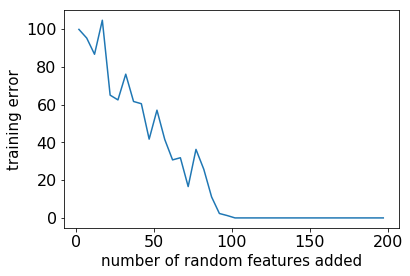

In [64]:
n = 100

training_errors = []
d_values = list(range(2,200,5))

for d in d_values:
    X = np.random.randn(n,d-1) 
    y = X[:,0] + np.random.randn(n) # y is just the first feature

    lr = LinearRegression()
    lr.fit(X,y)
    training_error = np.sum((lr.predict(X)-y)**2)
    training_errors.append(training_error)
    
plt.plot(d_values, training_errors);
plt.xlabel('number of random features added', fontsize=15)
plt.ylabel('training error', fontsize=15);

Note that we get to 0 training error when $d=n=100$ ($\pm 1$), as expected.

## Classifying loss functions

![](loss_venn2.jpg)